# Custom Layers in Keras

# Task 1: Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/src')

In [3]:
!ls

'Custom Activations using Layers - Complete.ipynb'   utils


In [12]:
#%cd "./utils"

/content/drive/My Drive/Colab Notebooks/src/utils


In [18]:
#!ls

Utils  utils.py


In [4]:
%run './utils/utils.py'

In [5]:
import tensorflow as tf
#import utils
import matplotlib.pyplot as plt
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.2.0


# Task 2: Import and Visualize Dataset

11493376/11490434 [==============================] - 0s 0us/step


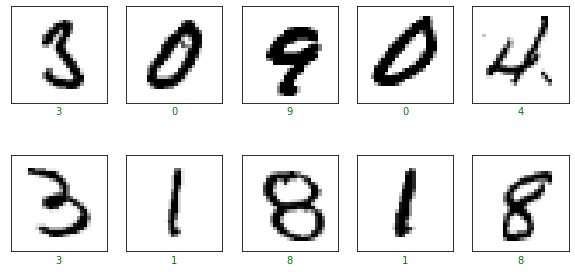

In [6]:
(x_train, y_train), (x_test, y_test) = load_data()

plot_random_examples(x_train, y_train).show()

 # Creating a Custom  Activations

# One way to create activations by inheriting keras.layers.Layer class

Most parameters of activation functions are derived from SELU paper

In [54]:
# For the absolute sake of simplicity I do not create a file and add these in them

# LEAKY RELU
"""
Avoids dead relu problem,however no alpha value is learned :/
"""

class leakyrelu(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(leakyrelu, self).__init__(**kwargs)
    
    def build(self, input_shape):
        #self.alpha = self.add_weight(name='minimum', shape=(1,),initializer='zeros',trainable=False)
        super(leakyrelu, self).build(input_shape)
    
    def call(self, x):
        alpha=tf.constant([0.01],shape=(1,),name='alpha') #chosing an arbitrary alpha value
        return tf.maximum(0., x) + alpha * tf.minimum(0., x)

# PARAMETRIC RELU
"""
Like Leaky ReLu but alpha parameter is a learnable paramter :D
"""

class ParametricRelu(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricRelu, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.alpha = self.add_weight(
            name='minimum', 
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        super(ParametricRelu, self).build(input_shape)
    
    def call(self, x):
        return tf.maximum(0., x) + self.alpha * tf.minimum(0., x)

# ELU

class Elu(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Elu, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.alpha = self.add_weight( name='minimum', shape=(1,),initializer='ones',trainable=True)
        super(Elu, self).build(input_shape)
    
    def call(self, x):
        return tf.maximum(0., x) + self.alpha * (tf.exp(tf.minimum(0., x))-1)


#SELU
"""
Scaled Elu
Note: Requires weight_init:'lecun_normal for self-normalization and AlphaDroput.
"""

class sElu(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(sElu, self).__init__(**kwargs)
    
    def build(self, input_shape):
        #self.alpha = self.add_weight( name='minimum', shape=(1,),initializer='lecun_normal',trainable=True)  
        super(sElu, self).build(input_shape)
    
    def call(self, x):  #Values from original author
      l=tf.constant([1.0507009873554804934193349852946],name='lambda')     #Scaling factors as derived by authors  
      a=tf.constant([1.6732632423543772848170429916717],name='alpha')      #Alpha as derived by authors

      return l*(tf.maximum(0., x) + (a* tf.exp(tf.minimum(0., x)-a)))

# Task 4: Creating the Model

In [55]:
def create_model(use):
    model = tf.keras.models.Sequential()
    if use=='selu':
      winit='lecun_normal' #As required by SELU authors
    else:
      winit='glorot_uniform'

    model.add(tf.keras.layers.Dense(64, input_shape=(784,),kernel_initializer=winit))
    if use == 'relu':
        model.add(tf.keras.layers.ReLU())
    elif use== 'prelu':
        model.add(ParametricRelu())
    elif use== 'leakyrelu':
        model.add(leakyrelu())
    elif use== 'elu' :
        model.add(Elu())
    elif use== 'selu' :
        model.add(sElu())
        
    model.add(tf.keras.layers.Dense(10, activation='softmax',kernel_initializer=winit))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(use='elu')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                50240     
_________________________________________________________________
elu_3 (Elu)                  (None, 64)                1         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                650       
Total params: 50,891
Trainable params: 50,891
Non-trainable params: 0
_________________________________________________________________


In [73]:
#model.layers[1].get_weights()

[array([0.], dtype=float32)]

# ELU

In [56]:
import time
start=time.time()
print('Initial alpha:', model.layers[1].get_weights())

h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7
)

print('Final alpha:', model.layers[1].get_weights())
print(time.time()-start)

Initial alpha: [array([1.], dtype=float32)]
Epoch 1/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3257 - accuracy: 0.9067 - val_loss: 0.2008 - val_accuracy: 0.9393
Epoch 2/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1680 - accuracy: 0.9504 - val_loss: 0.1427 - val_accuracy: 0.9590
Epoch 3/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1174 - accuracy: 0.9650 - val_loss: 0.1066 - val_accuracy: 0.9683
Epoch 4/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0910 - accuracy: 0.9724 - val_loss: 0.1000 - val_accuracy: 0.9717
Epoch 5/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0731 - accuracy: 0.9781 - val_loss: 0.0890 - val_accuracy: 0.9724
Epoch 6/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0620 - accuracy: 0.9809 - val_loss: 0.0840 - val_accuracy: 0.9741
Epoch 7/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0513 - accuracy: 0.98

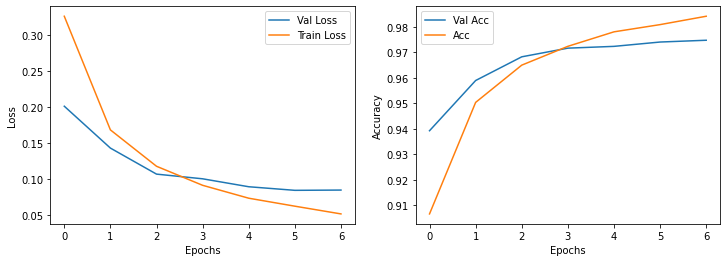

In [57]:
plot_results(h).show()

# SELU

In [58]:

model = create_model(use='selu')
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                50240     
_________________________________________________________________
s_elu_3 (sElu)               (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [59]:
import time
start=time.time()
print('Initial alpha:', model.layers[1].get_weights())

h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7
)

print('Final alpha:', model.layers[1].get_weights())
print(time.time()-start)

Initial alpha: []
Epoch 1/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3184 - accuracy: 0.9084 - val_loss: 0.1805 - val_accuracy: 0.9466
Epoch 2/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1601 - accuracy: 0.9523 - val_loss: 0.1330 - val_accuracy: 0.9598
Epoch 3/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1144 - accuracy: 0.9654 - val_loss: 0.1045 - val_accuracy: 0.9675
Epoch 4/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0885 - accuracy: 0.9733 - val_loss: 0.0952 - val_accuracy: 0.9709
Epoch 5/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0718 - accuracy: 0.9785 - val_loss: 0.0924 - val_accuracy: 0.9708
Epoch 6/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0599 - accuracy: 0.9811 - val_loss: 0.0866 - val_accuracy: 0.9726
Epoch 7/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0503 - accuracy: 0.9843 - val_loss: 0.0868 - va

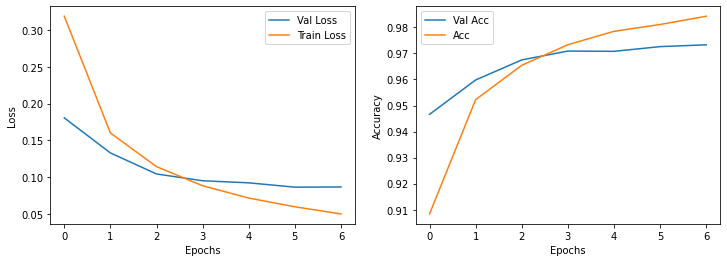

In [60]:
plot_results(h).show()

# PRELU

In [61]:
model = create_model(use='prelu')
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 64)                50240     
_________________________________________________________________
parametric_relu_1 (Parametri (None, 64)                1         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                650       
Total params: 50,891
Trainable params: 50,891
Non-trainable params: 0
_________________________________________________________________


In [62]:
import time
start=time.time()
print('Initial alpha:', model.layers[1].get_weights())
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7
)
print('Final alpha:', model.layers[1].get_weights())
print(time.time()-start)

Initial alpha: [array([0.], dtype=float32)]
Epoch 1/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2943 - accuracy: 0.9169 - val_loss: 0.1568 - val_accuracy: 0.9527
Epoch 2/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1272 - accuracy: 0.9625 - val_loss: 0.1051 - val_accuracy: 0.9688
Epoch 3/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0900 - accuracy: 0.9729 - val_loss: 0.1029 - val_accuracy: 0.9706
Epoch 4/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0710 - accuracy: 0.9779 - val_loss: 0.0945 - val_accuracy: 0.9739
Epoch 5/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0555 - accuracy: 0.9829 - val_loss: 0.0931 - val_accuracy: 0.9731
Epoch 6/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0466 - accuracy: 0.9854 - val_loss: 0.0959 - val_accuracy: 0.9726
Epoch 7/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0409 - accuracy: 0.98

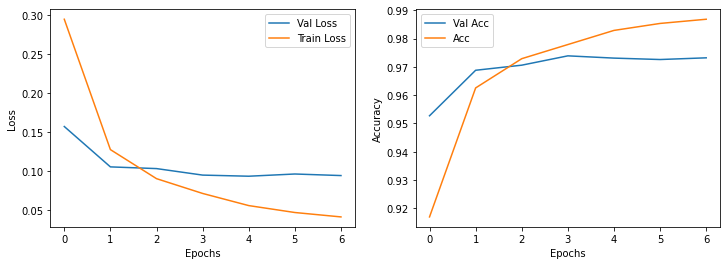

In [63]:
plot_results(h).show()

# Leaky Relu

In [64]:
model = create_model(use='leakyrelu')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                50240     
_________________________________________________________________
leakyrelu_4 (leakyrelu)      (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [65]:
import time
start=time.time()
print('Initial alpha:', model.layers[1].get_weights())
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7
)
print('Final alpha:', model.layers[1].get_weights())
print(time.time()-start)

Initial alpha: []
Epoch 1/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3022 - accuracy: 0.9158 - val_loss: 0.1655 - val_accuracy: 0.9521
Epoch 2/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1455 - accuracy: 0.9579 - val_loss: 0.1265 - val_accuracy: 0.9616
Epoch 3/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060 - accuracy: 0.9687 - val_loss: 0.1046 - val_accuracy: 0.9685
Epoch 4/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0842 - accuracy: 0.9754 - val_loss: 0.0961 - val_accuracy: 0.9714
Epoch 5/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0696 - accuracy: 0.9792 - val_loss: 0.0926 - val_accuracy: 0.9710
Epoch 6/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0594 - accuracy: 0.9825 - val_loss: 0.0804 - val_accuracy: 0.9752
Epoch 7/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0496 - accuracy: 0.9854 - val_loss: 0.0823 - va

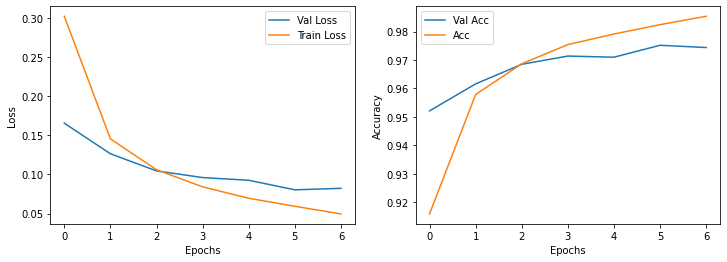

In [66]:
plot_results(h).show()

# Method 2 for creating activation functions

In [67]:
# Creating swish and GELU

In [86]:
from keras.backend import sigmoid
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

def custom_gelu(x):  #Used in BERT and GPT2 paper yet to read completely
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))


get_custom_objects().update({'custom_gelu': Activation(custom_gelu)})
get_custom_objects().update({'swish': Activation(swish)})


In [99]:
def create_model(use):
    model = tf.keras.models.Sequential()
    if use=='gelu':
      model.add(tf.keras.layers.Dense(64, input_shape=(784,),activation=custom_gelu))
    else:
      model.add(tf.keras.layers.Dense(64, input_shape=(784,),activation=use)) 
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(use='gelu')
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_55 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


# EDIT: layers[1].get_weights() prints first layers weights than the activation fucntion in previous case

In [92]:
import time
start=time.time()
print('Initial alpha:', model.layers[1].get_weights())
gh = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7
)
print('Final alpha:', model.layers[1].get_weights())
print(time.time()-start)

Initial alpha: [array([[ 0.12353632,  0.16423404,  0.10222274,  0.1256558 , -0.01892754,
        -0.02012911,  0.04866058,  0.12828976, -0.08458149, -0.14631438],
       [-0.18274339,  0.05565363, -0.1672585 ,  0.27012166,  0.25833252,
         0.14464161,  0.04973227, -0.16902003, -0.037247  ,  0.19368479],
       [-0.1621024 , -0.1792361 , -0.13050628, -0.08876258, -0.07096566,
        -0.01914582, -0.23445225, -0.13684182,  0.1989077 , -0.02570578],
       [ 0.12473157,  0.1441727 ,  0.09397429,  0.00332046, -0.18190944,
         0.01261935,  0.04458568,  0.16517016,  0.1471281 ,  0.1981079 ],
       [ 0.09285513,  0.07188725, -0.09558456,  0.274725  ,  0.15193444,
        -0.15837169, -0.27295187,  0.04262924, -0.12887274, -0.18479514],
       [ 0.18666595,  0.19486734, -0.10955802,  0.2639028 , -0.05440684,
         0.1187984 ,  0.10627389, -0.0036768 , -0.05467792, -0.03288031],
       [-0.28256285, -0.01646656,  0.22653136,  0.14125109,  0.04477257,
         0.18957227, -0.12007

In [98]:

model = create_model(use='swish')
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_53 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [100]:
import time
start=time.time()
print('Initial alpha:', model.layers[1].get_weights())
sh = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=7
)
print('Final alpha:', model.layers[1].get_weights())
print(time.time()-start)

Initial alpha: [array([[ 0.02084643, -0.16138217,  0.2829087 ,  0.14652565, -0.18471095,
        -0.12087099,  0.16201237, -0.00325066, -0.06640942,  0.10206673],
       [ 0.2119534 , -0.2558481 , -0.01877779,  0.24446562,  0.14282861,
        -0.2140877 , -0.00336966,  0.1178225 ,  0.06388301, -0.25829393],
       [-0.00031894,  0.06267378, -0.16316961,  0.00606263,  0.14348754,
        -0.06689693,  0.21690711,  0.05176529, -0.01930445, -0.1682317 ],
       [ 0.00494301, -0.2725569 , -0.2420508 , -0.11959603, -0.15769775,
         0.21959278, -0.00450423, -0.22490624, -0.18821198, -0.03454033],
       [ 0.2697967 ,  0.25885156, -0.06789531,  0.22188452, -0.06498179,
        -0.07024346,  0.26663217,  0.07309249, -0.1939106 ,  0.20388949],
       [ 0.22402522, -0.06327668,  0.18563873, -0.01840398,  0.07488164,
         0.06559807,  0.23722163,  0.0770376 ,  0.27612635,  0.01703215],
       [ 0.10302907, -0.07591681, -0.05564269,  0.0057731 ,  0.18928951,
         0.03045416, -0.22046

Looks like GELU can help in deeper networks 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

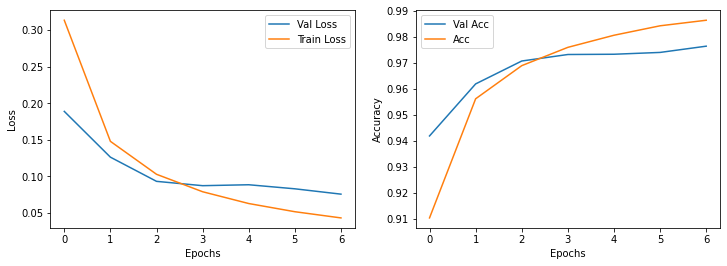

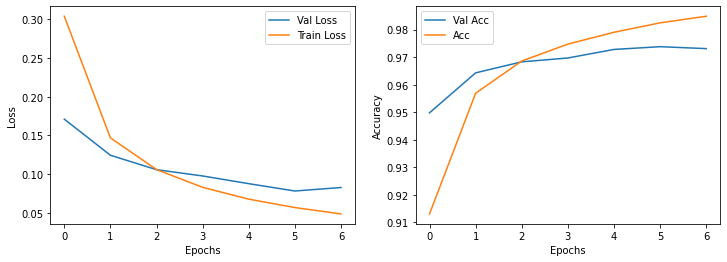

In [104]:
plot_results(gh)
plot_results(sh)